In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !unrar x "/content/drive/MyDrive/Colab Notebooks/arabic_ocr/data.rar" "/content/drive/MyDrive/Colab Notebooks/arabic_ocr/"

### import the needed libraries

In [1]:
#important library imports
import numpy as np
import cv2
import os
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv

### get each file name and sort their names 

In [2]:
# get each file name and sort theis names 
filenames_img=sorted(os.listdir('./data/images'))
filenames_labels=sorted(os.listdir('./data/labels'))
filenames_imgs_split=[filename.replace('.jpg', '') for filename in filenames_img]
filenames_labels_split=[filename.replace('.txt', '') for filename in filenames_labels]
print(len(filenames_imgs_split))
print(len(filenames_labels_split))

19628
19628


### split data into training and testing

In [3]:
#train test validate splitting
split_idx = int(0.95 * len(filenames_imgs_split))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgs_split[:split_idx]
test_samples = filenames_img[split_idx:]
test_samples_split = filenames_imgs_split[split_idx:]


print(f"Total training samples: {len(train_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 18646
Total test samples: 982


### get each image path and each text(label) content

In [4]:
base_path='./data/'
base_image_path = os.path.join(base_path, "images/")
base_labels_path = os.path.join(base_path, "labels/")
def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []
    for i in tqdm(range(len(filenames_imgsplit))):
        img_path = os.path.join(
            base_image_path,  filenames_img[i]
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            label_path = os.path.join(
            base_labels_path,  filenames_imgsplit[i]+'.txt'
        )
        label_file = open(label_path, "r",  encoding="utf8")
        labels.append(label_file.read())

    return paths, labels

In [5]:
test_images_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

100%|██████████████████████████████████████████████████████████████████████████████| 982/982 [00:00<00:00, 4089.75it/s]


### create Function that load and build the lookup mapper

In [6]:
def load_StringLookup():
    '''
        this function load the characters from vocabulary txt file 
        then build the lookup mapper again 
        and return the mapper
    '''

    # Load the vocabulary from the saved file
    with open('vocabulary.txt', 'r', encoding='utf-8') as vocab_file:
        vocabulary = vocab_file.read().split('\n')

    # Create a new StringLookup layer with the loaded vocabulary and configuration
    char_to_num = tf.keras.layers.StringLookup(
        vocabulary=vocabulary,
        mask_token=None,  # You may need to adjust this depending on your configuration
    )
    
    # Mapping integers back to original characters.
    num_to_char = StringLookup(
        vocabulary= vocabulary, mask_token=None, invert=True
    )
    return char_to_num, num_to_char

In [7]:
char_to_num, num_to_char = load_StringLookup()

### Create the image processing Functions that load the image from image paths then return numpy array of all images

In [8]:
def preprocess_image(image_paths, width, hight):
    images = []
    for path in tqdm(image_paths):
        # Load and preprocess your images here (e.g., resizing and normalizing)
        image = cv2.imread(path)  # Load the image using OpenCV
        image = cv2.resize(image, (width, hight))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, image = cv2.threshold(image, 250, 255, cv2.THRESH_BINARY)

        image = image // 255.0  # Normalize pixel values to [0, 1]

        images.append(image)
    # Next we need to reshape our data for the convolutional network
    images=np.array(images)
    images = images.reshape(images.shape[0], hight, width,1)
    return images


### create function the vectorize the label text

In [9]:
padding_token = 99
max_len = 68
def vectorize_label(labels):
    vectorized_labels=[]
    for label in tqdm(labels):
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        length = tf.shape(label)[0]
        pad_amount = max_len - length
        label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
        vectorized_labels.append(label)
    return np.array( vectorized_labels)

In [10]:
test_vectorized_labels = vectorize_label(test_labels)

100%|███████████████████████████████████████████████████████████████████████████████| 982/982 [00:03<00:00, 299.58it/s]


In [11]:
test_images = preprocess_image(test_images_paths, 300, 20)

100%|██████████████████████████████████████████████████████████████████████████████| 982/982 [00:00<00:00, 1282.51it/s]


1159 شارع شيلود متفرع من كيربريجي في ١١٣٩ بينارث


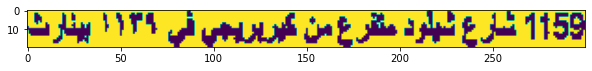

In [12]:
i=20
print(test_labels[i])
plt.figure(figsize=(10,6))
image = test_images[i]
plt.imshow(image)

### create a CTC Loss Function which is our loss function

In [13]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

### load the whole model and create the usable prediction model

In [14]:
model = keras.models.load_model('./models/my_model_final.h5', custom_objects={'CTCLayer': CTCLayer})

In [21]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense3").output
)
prediction_model.save('./models/my_prediction_model_final.h5')

### Create function that decode the model output and map it to final predicted text

In [17]:
max_len=68
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

### test the model

In [18]:
test = preprocess_image([test_images_paths[1]], 300, 20)
preds = prediction_model.predict(test)
print("actual text: ", test_labels[1]) 
print("predicted text: ",decode_batch_predictions(preds)[0])

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 396.44it/s]


1/1 [==============================] - 2s 2s/step
actual text:  568 شارع الغوير متفرع من سوميا في ١٥١٢ أم المهابيش
predicted text:  94 شارع الدوير متفرع من سوميا في ١٠١١ أم البيابين


In [19]:
model.evaluate([test_images, test_vectorized_labels])

31/31 [==============================] - 9s 221ms/step - loss: 41.5680


41.56802749633789

### Save a ONNX Model

In [21]:
import tf2onnx

tf2onnx.convert.from_keras(prediction_model, output_path='./my_prediction_model_final.onnx');
tf2onnx.convert.from_keras(prediction_model, output_path='./my_model_final.onnx');